# Effect of instantaneous weather sampling rate on subhourly clipping errors
These notebooks resample the NIST weather station data at different frequencies to simulate satellite data.

In [1]:
# import glob
import logging
import pathlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5, rc={'figure.figsize': (16, 10)})
logging.basicConfig()
LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

In [2]:
# get glob of weather files
weather_dir = pathlib.Path('onemin-WS_1-2017')
weather_glob = weather_dir.glob('*.csv')

## Load NIST monthly weather data
Each month is in a separate file. The date/time column is "TIMESTAMP" and the timezone is already localized with an offset of -0500 hours for the US/Eastern timezone. Calling `tz_localize()` on the datetime indices with `None` removes the timzeone from the timestamps but leaves the local time as is, without conversion. This is important because SolarFarmer expects local time without timezone.

In [3]:
weather_data = []
for weather_file in weather_glob:
    LOGGER.debug(weather_file)
    ws_mo = pd.read_csv(
        weather_file,
        index_col='TIMESTAMP',
        parse_dates=['TIMESTAMP'])
    ws_mo.index = ws_mo.index.tz_localize(None)
    weather_data.append(ws_mo)
ws = pd.concat(weather_data)

DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-01.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-02.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-03.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-04.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-05.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-06.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-07.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-08.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-09.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-10.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-11.csv
DEBUG:root:onemin-WS_1-2017\onemin-WS_1-2017-12.csv


In [4]:
len(weather_data)

12

In [5]:
ws.columns

Index(['Pyrh1_Wm2_Avg', 'Pyrad1_Wm2_Avg', 'Pyra1_Wm2_Avg', 'Pyrg1_Wm2_Avg',
       'UVA_Wm2_Avg', 'UVB_Wm2_Avg', 'Pyrg1_downwell_Wm2_Avg', 'RECORD',
       'SolarTime_hr', 'SolarTime_hr_Med', 'SolarZenith_deg_Avg',
       'SolarAzFromSouth_deg_Avg', 'Declination_deg_Avg', 'AirMass_Avg',
       'CR1000Temp_C_Avg', 'DoorOpen_Min', 'RainTB_mm_Tot', 'Vent2_rpm_Avg',
       'Pyrh1temp_C_Avg', 'Pyrg1temp_C_Avg', 'Pyra1temp_C_Avg',
       'UVBtemp_C_Avg', 'RefCell1_Wm2_Avg', 'RefCell2_Wm2_Avg',
       'RefCell3_Wm2_Avg', 'RefCell4_Wm2_Avg', 'RefCell5_Wm2_Avg',
       'RefCell6_Wm2_Avg', 'WindSpeedAve_ms', 'WindDirAve_deg',
       'WindDirStdDev_deg', 'WindSpeed_ms_Max', 'AirTemp_C_Avg',
       'RelHumid_Avg', 'AirPres_kPa_Avg', 'Rain_mm_Tot', 'Hail_hitssqrcm_Tot',
       'SixInOneRef_V_Min', 'SixInOneHeatStateID_Avg', 'WindValid_Avg',
       'Battery_V_Min', 'Battery_A_Avg', 'Load_A_Avg', 'ChgState_Min',
       'ChgSource_Min', 'CkBatt_Max', 'Qloss_Ah_Max', 'RelayState_Min'],
      dtype='obj

In [6]:
ws.index

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 00:01:00',
               '2017-01-01 00:02:00', '2017-01-01 00:03:00',
               '2017-01-01 00:04:00', '2017-01-01 00:05:00',
               '2017-01-01 00:06:00', '2017-01-01 00:07:00',
               '2017-01-01 00:08:00', '2017-01-01 00:09:00',
               ...
               '2017-12-31 23:50:00', '2017-12-31 23:51:00',
               '2017-12-31 23:52:00', '2017-12-31 23:53:00',
               '2017-12-31 23:54:00', '2017-12-31 23:55:00',
               '2017-12-31 23:56:00', '2017-12-31 23:57:00',
               '2017-12-31 23:58:00', '2017-12-31 23:59:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=525600, freq=None)

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'Pyrh1_Wm2_Avg'`
* global horizontal irradiance (GHI): `'Pyra1_Wm2_Avg'`
* diffuse horizontal irradiance (DHI): `'Pyrad1_Wm2_Avg'`
* solar zenith: `'SolarZenith_deg_Avg'`
* wind speed: `'WindSpeedAve_ms'`
* air temperature: `'AirTemp_C_Avg'`

In [7]:
# view a few timestamps to sanity check (E. Tufte, ...)
data_cols = ['Pyrh1_Wm2_Avg', 'Pyra1_Wm2_Avg', 'Pyrad1_Wm2_Avg', 'SolarZenith_deg_Avg', 'WindSpeedAve_ms', 'AirTemp_C_Avg']
ws['2017-01-01 12:09':'2017-01-01 12:18'][data_cols]  # <-- XXX: pick dates for each month

,Pyrh1_Wm2_Avg,Pyra1_Wm2_Avg,Pyrad1_Wm2_Avg,SolarZenith_deg_Avg,WindSpeedAve_ms,AirTemp_C_Avg
TIMESTAMP,,,,,,
2017-01-01 12:09:00,712.166200,533.551427,206.101695,62.06,3.568,9.40
2017-01-01 12:10:00,619.436230,485.484685,202.824854,62.05,3.723,9.40
2017-01-01 12:11:00,693.743826,519.046697,200.451983,62.05,3.255,9.38
2017-01-01 12:12:00,602.497545,473.309213,198.531070,62.05,3.260,9.30
2017-01-01 12:13:00,625.494562,484.637705,199.209041,62.05,3.397,9.29
2017-01-01 12:14:00,536.968340,433.500590,191.299430,62.05,3.655,9.20
2017-01-01 12:15:00,417.532158,368.705800,182.937848,62.05,3.768,9.28
2017-01-01 12:16:00,446.711167,383.845753,182.937848,62.05,4.002,9.23
2017-01-01 12:17:00,705.242334,513.858899,190.847459,62.05,3.575,9.20


## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [8]:
dni = np.maximum(0, ws['Pyrh1_Wm2_Avg'])
ghi = np.maximum(0, ws['Pyra1_Wm2_Avg'])
dif = np.maximum(0, ws['Pyrad1_Wm2_Avg'])
zerad = np.radians(ws['SolarZenith_deg_Avg'])
dhi = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI')
irrad = pd.concat([dni, ghi, dif, dhi], axis=1)

<AxesSubplot:xlabel='TIMESTAMP'>

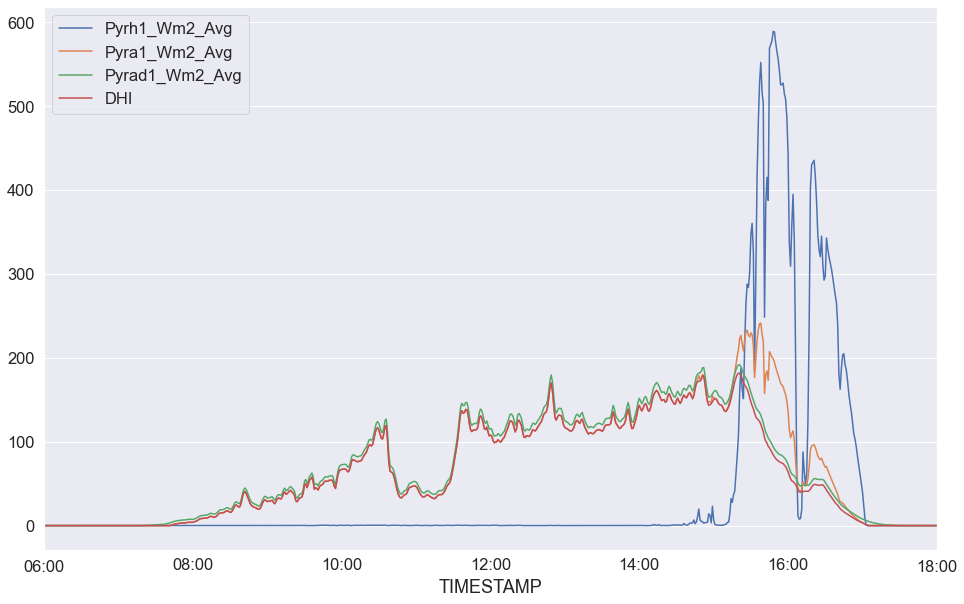

In [9]:
LOGGER.setLevel(logging.ERROR)
irrad['2017-01-07 06:00':'2017-01-07 18:00'].plot()  # <-- XXX: pick dates for each month

<AxesSubplot:xlabel='TIMESTAMP'>

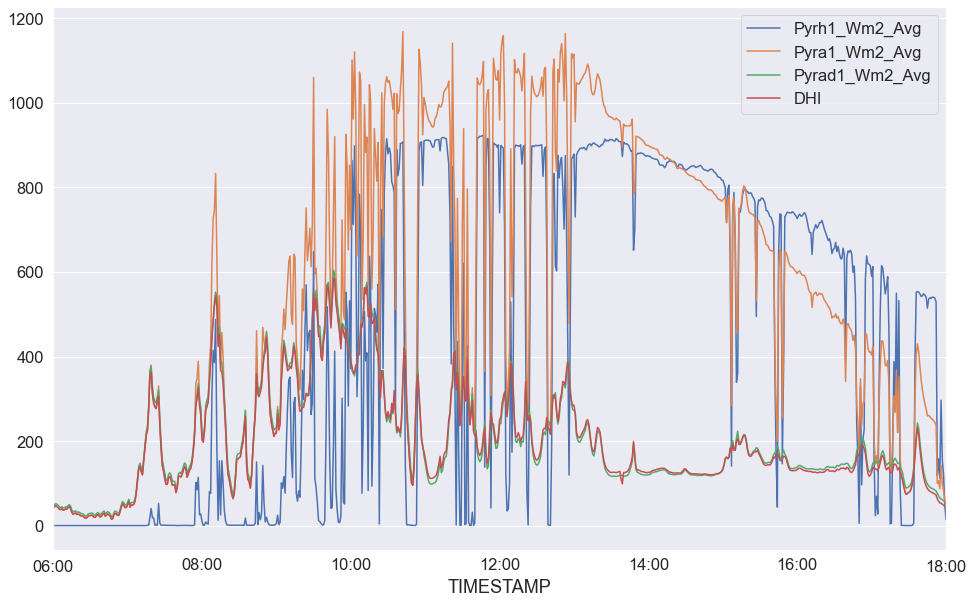

In [20]:
irrad['2017-07-07 06:00':'2017-07-07 18:00'].plot()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI (_AKA_: DIF)
3. Temp
4. WS

In [10]:
# get other parameters needed for modeling like windspeed and air temp
wspd = ws['WindSpeedAve_ms']
tair = ws['AirTemp_C_Avg']

In [11]:
weather = pd.concat([ghi, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DIF', 'Temp', 'WS']
weather.head()

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-01 00:00:00,0.0,0.0,6.8,4.455
2017-01-01 00:01:00,0.0,0.0,6.8,5.733
2017-01-01 00:02:00,0.0,0.0,6.8,6.420
2017-01-01 00:03:00,0.0,0.0,6.8,4.582
2017-01-01 00:04:00,0.0,0.0,6.8,3.503


In [12]:
weather.loc['2017-01-01 08:22']  # <-- XXX: pick dates for each month

GHI     90.786857
DIF     80.998522
Temp     4.800000
WS       0.312000
Name: 2017-01-01 08:22:00, dtype: float64

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [13]:
every5min = list(range(2, 60, 5))
every5min

[2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57]

### Shift index
We need the timestamp to be at the start of the sampling interval

In [14]:
weather5inst = weather[weather.index.minute.isin(every5min)].shift(freq='-2min')
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min['2017-01-07 06:00':'2017-01-07 18:00']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 06:00:00,0.000000,0.000000,-6.988583,3.258083
2017-01-07 07:00:00,0.776408,0.776408,-7.271583,3.278500
2017-01-07 08:00:00,18.272068,18.272068,-8.147500,2.869333
2017-01-07 09:00:00,42.684821,42.657985,-8.020417,2.917083
2017-01-07 10:00:00,73.635285,73.556857,-7.341417,4.200917
2017-01-07 11:00:00,79.537754,79.466018,-7.667833,4.801167
2017-01-07 12:00:00,119.125764,119.081536,-7.541667,5.051333
2017-01-07 13:00:00,119.064004,119.064004,-6.548833,4.416083
2017-01-07 14:00:00,153.190686,152.304318,-5.927000,6.195250


## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [15]:
every15min = list(range(7, 60, 15))
every15min

[7, 22, 37, 52]

In [16]:
weather15inst = weather[weather.index.minute.isin(every15min)].shift(freq='-7min')
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min['2017-01-07 06:00':'2017-01-07 18:00']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 06:00:00,0.000000,0.000000,-7.00000,3.69800
2017-01-07 07:00:00,0.780820,0.780820,-7.30500,3.71550
2017-01-07 08:00:00,16.357515,16.357515,-8.13500,2.61225
2017-01-07 09:00:00,42.825985,42.815403,-8.04750,2.96825
2017-01-07 10:00:00,76.070385,76.032804,-7.34925,4.01975
2017-01-07 11:00:00,85.307881,85.221844,-7.67650,5.46100
2017-01-07 12:00:00,117.467074,117.422685,-7.55000,4.73875
2017-01-07 13:00:00,120.060984,120.060984,-6.55000,3.98825
2017-01-07 14:00:00,154.522931,154.153215,-5.92500,6.40725


## Ditto 60-minutes

In [17]:
weather30inst = weather[weather.index.minute.isin([15, 45])].shift(freq='-15min')
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min['2017-01-07 06:00':'2017-01-07 18:00']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 06:00:00,0.000000,0.000000,-6.9765,2.7155
2017-01-07 07:00:00,0.820523,0.820523,-7.2500,3.0915
2017-01-07 08:00:00,20.963028,20.963028,-8.1450,2.2555
2017-01-07 09:00:00,43.567102,43.506050,-8.0000,2.9495
2017-01-07 10:00:00,58.812941,58.663682,-7.3085,3.2270
2017-01-07 11:00:00,72.153050,72.067754,-7.6300,4.9305
2017-01-07 12:00:00,128.530893,128.501291,-7.5500,4.3475
2017-01-07 13:00:00,119.161052,119.161052,-6.5035,4.8150
2017-01-07 14:00:00,161.351797,160.839029,-5.9240,6.1490


# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

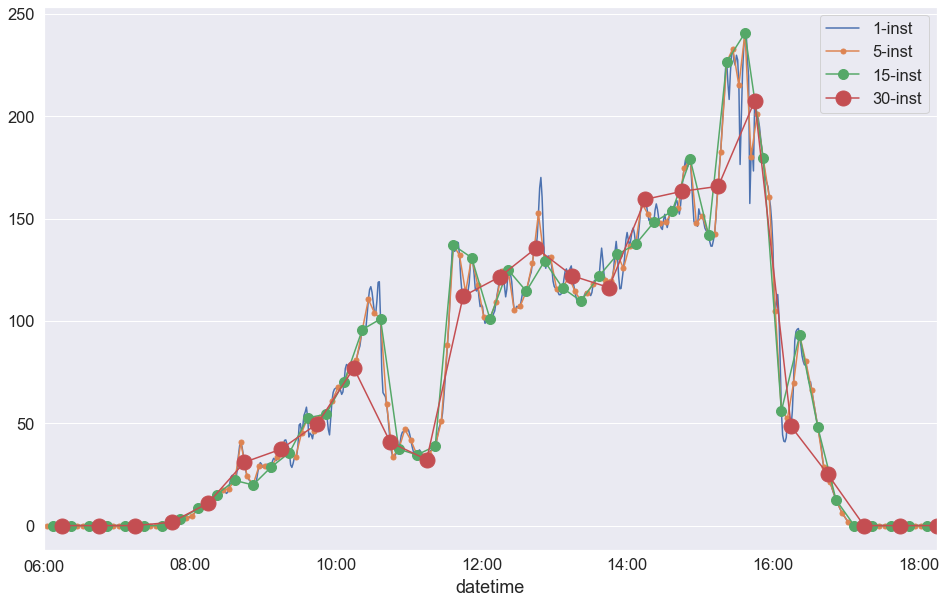

In [18]:
ax = weather['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot()
weather5inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='2min').plot(ax=ax, marker='o', ms=5)
weather15inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o', ms=10)
weather30inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])

Text(0, 0.5, 'GHI $[W/m^2]$')

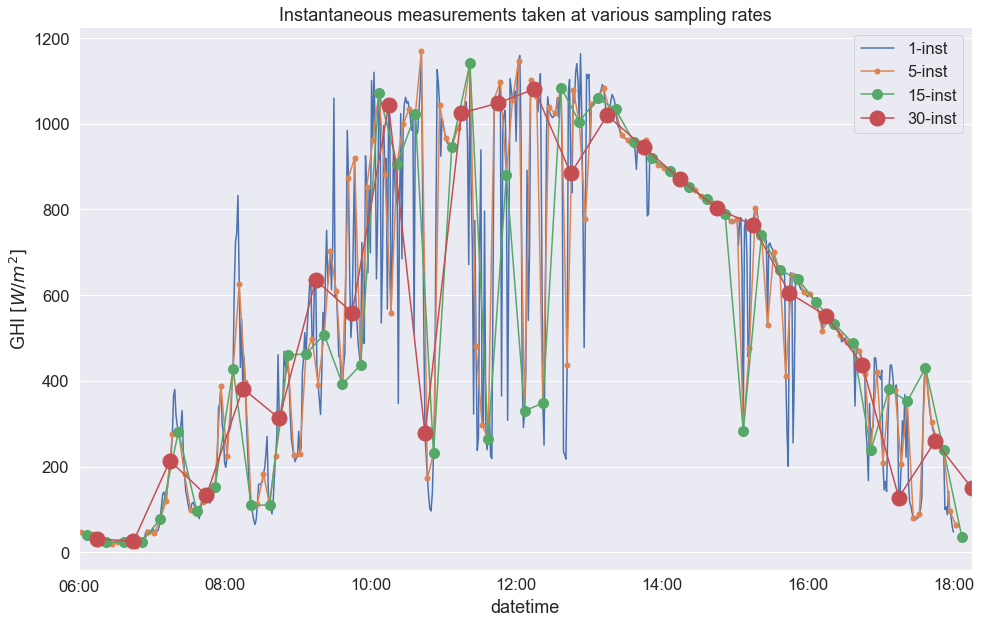

In [41]:
ax = weather['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot()
weather5inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='2min').plot(ax=ax, marker='o', ms=5)
weather15inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o', ms=10)
weather30inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='15min').plot(ax=ax, marker='o', ms=15)
plt.legend(['1-inst', '5-inst', '15-inst', '30-inst'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

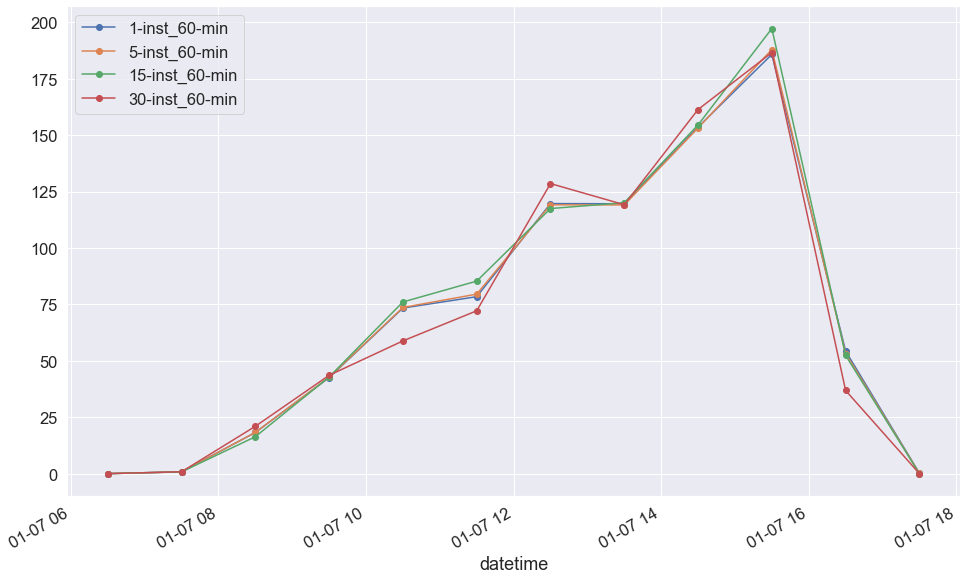

In [19]:
ax = weather.resample('H').mean().shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])

Text(0, 0.5, 'GHI $[W/m^2]$')

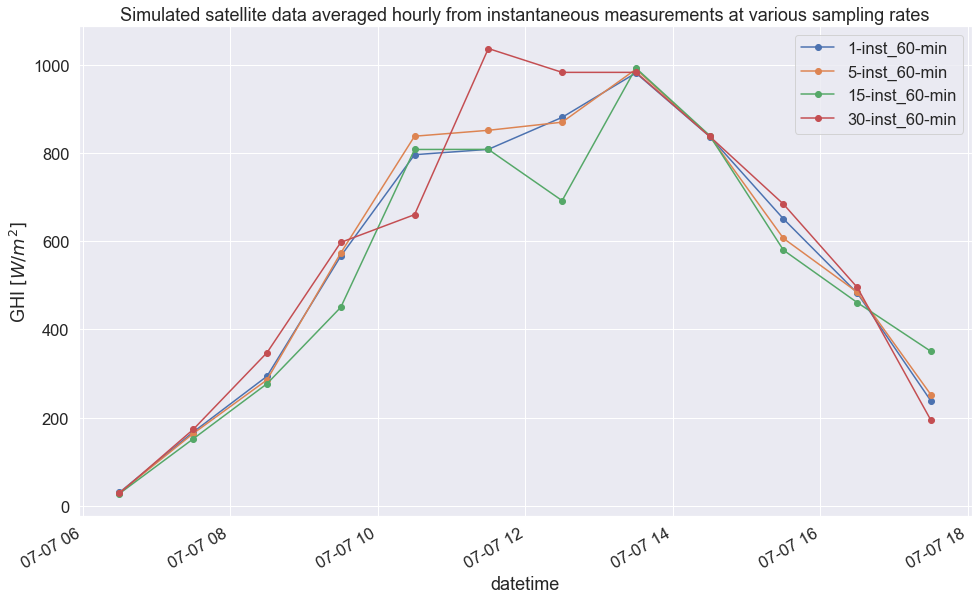

In [42]:
ax = weather.resample('H').mean().shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [23]:
weather.resample('H').mean()['2017-01-07 06:00':'2017-01-07 18:00']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 06:00:00,0.000000,0.000000,-6.992967,3.227533
2017-01-07 07:00:00,0.790525,0.790525,-7.276100,3.293867
2017-01-07 08:00:00,18.227953,18.227574,-8.147500,2.910450
2017-01-07 09:00:00,42.550713,42.516143,-8.012917,2.969667
2017-01-07 10:00:00,73.368836,73.267328,-7.352433,3.743900
2017-01-07 11:00:00,78.406669,78.320570,-7.671617,4.521783
2017-01-07 12:00:00,119.665720,119.619530,-7.543150,4.976567
2017-01-07 13:00:00,119.581022,119.581022,-6.553650,4.440033
2017-01-07 14:00:00,153.534776,152.696067,-5.934333,5.969433


## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

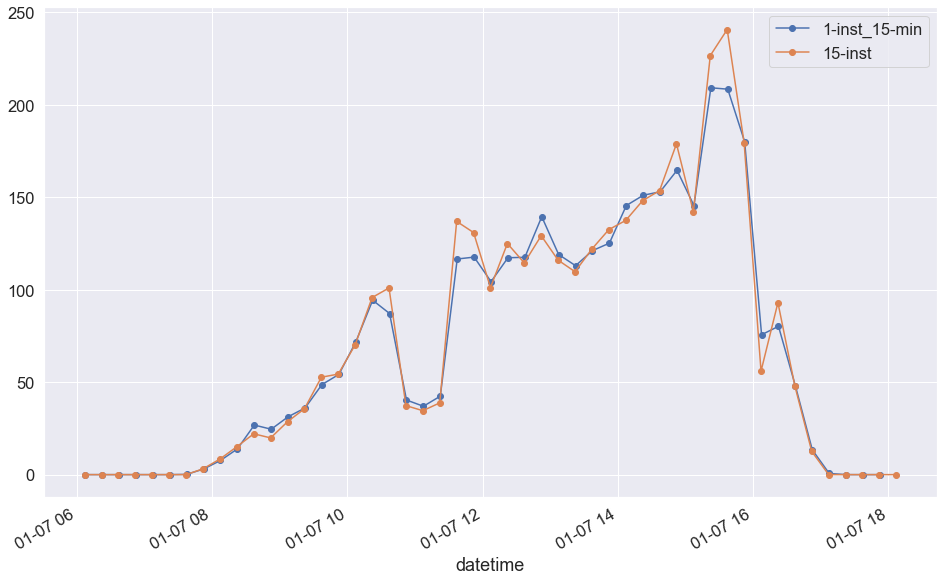

In [24]:
ax = weather.resample('15T').mean().shift(freq='450s')['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].plot(marker='o')
weather15inst['2017-01-07 06:00':'2017-01-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

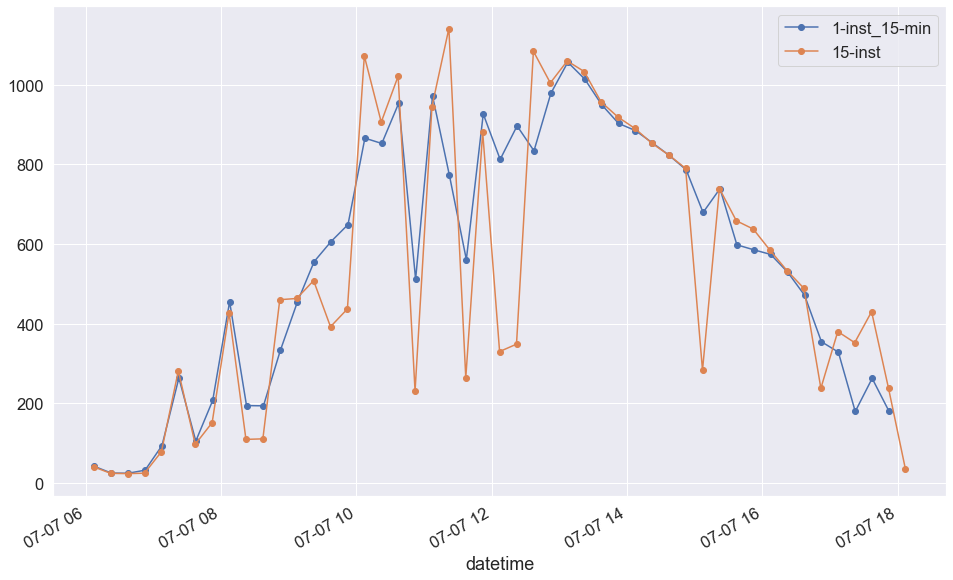

In [25]:
ax = weather.resample('15T').mean().shift(freq='450s')['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].plot(marker='o')
weather15inst['2017-07-07 06:00':'2017-07-07 18:00']['GHI'].shift(freq='7min').plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [26]:
weather.resample('15T').mean()['2017-01-07 10:30':'2017-01-07 13:30']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 10:30:00,87.123619,86.987446,-7.178467,4.377800
2017-01-07 10:45:00,40.341478,40.270652,-7.183933,4.105800
2017-01-07 11:00:00,36.967631,36.919949,-7.438400,4.830600
2017-01-07 11:15:00,42.423664,42.336746,-7.841000,4.561200
2017-01-07 11:30:00,116.605966,116.497998,-7.915533,4.487000
2017-01-07 11:45:00,117.629414,117.527588,-7.491533,4.208333
2017-01-07 12:00:00,104.366945,104.284244,-7.497467,5.537867
2017-01-07 12:15:00,117.283558,117.212542,-7.559333,5.247600
2017-01-07 12:30:00,117.530597,117.530597,-7.620533,4.666533


# save output
Save the files we need to run SolarFarmer

In [27]:
month = 'allmonths'
output_dir = pathlib.Path(f'instantaneous_{month}')
output_dir.mkdir(exist_ok=False)  # <-- January is already done

In [29]:
weather5inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst.tab', sep='\t')
weather5inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_5-inst_60-min.tab', sep='\t')

In [30]:
weather15inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst.tab', sep='\t')
weather15inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_15-inst_60-min.tab', sep='\t')

In [31]:
weather30inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst.tab', sep='\t')
weather30inst60min.dropna().to_csv(output_dir / f'NIST_{month}-2017_30-inst_60-min.tab', sep='\t')

In [32]:
weather60inst = weather[weather.index.minute.isin([30])].shift(freq='-30min')
weather60inst['2017-01-07 06:00':'2017-01-07 18:00']

,GHI,DIF,Temp,WS
datetime,,,,
2017-01-07 06:00:00,0.000000,0.000000,-7.000,2.868
2017-01-07 07:00:00,0.000000,0.000000,-7.100,2.478
2017-01-07 08:00:00,15.722272,15.722272,-8.200,2.838
2017-01-07 09:00:00,49.178420,49.104391,-8.000,2.625
2017-01-07 10:00:00,113.973235,113.823493,-7.200,3.587
2017-01-07 11:00:00,69.823827,69.766392,-8.000,4.498
2017-01-07 12:00:00,106.985561,106.985561,-7.680,4.405
2017-01-07 13:00:00,112.385129,112.385129,-6.485,4.728
2017-01-07 14:00:00,149.440990,149.174051,-5.900,6.188


In [33]:
weather60inst.dropna().to_csv(output_dir / f'NIST_{month}-2017_60-inst.tab', sep='\t')

# Time Averaged
This is the original clipping error problem.

In [34]:
weather.dropna().to_csv(output_dir / f'NIST_{month}-2017_1-min.tab', sep='\t')
weather.resample('5T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_5-min.tab', sep='\t')
weather.resample('15T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_15-min.tab', sep='\t')
weather.dropna().resample('30T').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_30-min.tab', sep='\t')
weather.resample('H').mean().dropna().to_csv(output_dir / f'NIST_{month}-2017_60-min.tab', sep='\t')